# 6 Final parameter estimates

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
from corner import corner
from scipy.stats import norm

In [2]:
%run src/core.py
%run plotting.py

In [12]:
df = derive_qois(read_mcmc('results/toi_263_tess_m2_lco.nc'))

In [15]:
parameters = 'tc p rho b inc teff_h k_app k_true r_true r_app a_st a_au t14_h teff_p'.split()
for p in parameters:
    pqs = percentile(df[p], [50, 16, 84, 99])
    print (f"{p:10} & {pqs[0]:20.7f} & {pqs[1]-pqs[0]:+15.7f} & {pqs[2]-pqs[0]:+15.7f} & P(99) {pqs[-1]:15.7f} \\\\")

tc         &      2458386.1715323 &      -0.0006106 &      +0.0006129 & P(99) 2458386.1729014 \\
p          &            0.5568153 &      -0.0000038 &      +0.0000036 & P(99)       0.5568243 \\
rho        &           10.8462906 &      -1.4679351 &      +0.9671855 & P(99)      12.8550893 \\
b          &            0.2215813 &      -0.1495337 &      +0.1667858 & P(99)       0.5088502 \\
inc        &           87.7492837 &      -1.8951349 &      +1.5366722 & P(99)      89.9527729 \\
teff_h     &         3253.5603170 &    -155.1847463 &    +164.4626371 & P(99)    3608.0362147 \\
k_app      &            0.1972902 &      -0.0035910 &      +0.0034235 & P(99)       0.2044652 \\
k_true     &            0.2165957 &      -0.0131845 &      +0.0285568 & P(99)       0.2788871 \\
r_true     &            0.8696765 &      -0.1741025 &      +0.1897919 & P(99)       1.3606985 \\
r_app      &            0.7760332 &      -0.1455849 &      +0.1500716 & P(99)       1.1240323 \\
a_st       &            5.6227

In [68]:
pars = 'k_app k_true r_true'.split()
names = 'ka kt rt'.split()
lims = 'median lower upper'.split()

for i,p in enumerate(pars):
    qs = df[p].quantile([0.5, 0.005, 0.995])
    for j,q in enumerate(qs):
        print(f"\\newcommand{{\\{names[i]}{lims[j]}}}{{{q:.3f}\\xspace}}")

\newcommand{\kamedian}{0.197\xspace}
\newcommand{\kalower}{0.188\xspace}
\newcommand{\kaupper}{0.205\xspace}
\newcommand{\ktmedian}{0.217\xspace}
\newcommand{\ktlower}{0.194\xspace}
\newcommand{\ktupper}{0.286\xspace}
\newcommand{\rtmedian}{0.870\xspace}
\newcommand{\rtlower}{0.435\xspace}
\newcommand{\rtupper}{1.414\xspace}


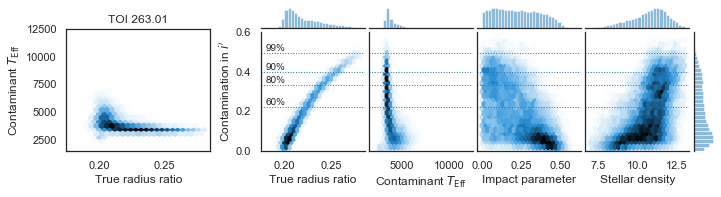

In [20]:
def joint_marginal_plot2(df, fw=10, nb=30, gs=25, **kwargs):
    return _jplot(df.k_true, df.teff_c, df.cnt, df.b, df.rho, fw, nb, gs, **kwargs)[0]

fig = joint_marginal_plot2(df, htelim=(0.18, 0.28), ctelim=(2000, 12000), rlim=(7,13), blim=(0.0, 0.6), clim=(0,0.6))
setp(fig.axes[0:2], xlabel='True radius ratio');
ps = percentile(df.cnt, [60, 80, 90, 99])
[[ax.axhline(p, lw=1, ls=':') for p in ps] for ax in fig.axes[1:5]]
[fig.axes[1].text(0.18, p+0.01, '{:2d}%'.format(t), size='small') for p,t in zip(ps, [60, 80, 90, 99])]
fig.axes[0].set_title('TOI 263.01');
fig.savefig('plots/contamination_posteriors.pdf')

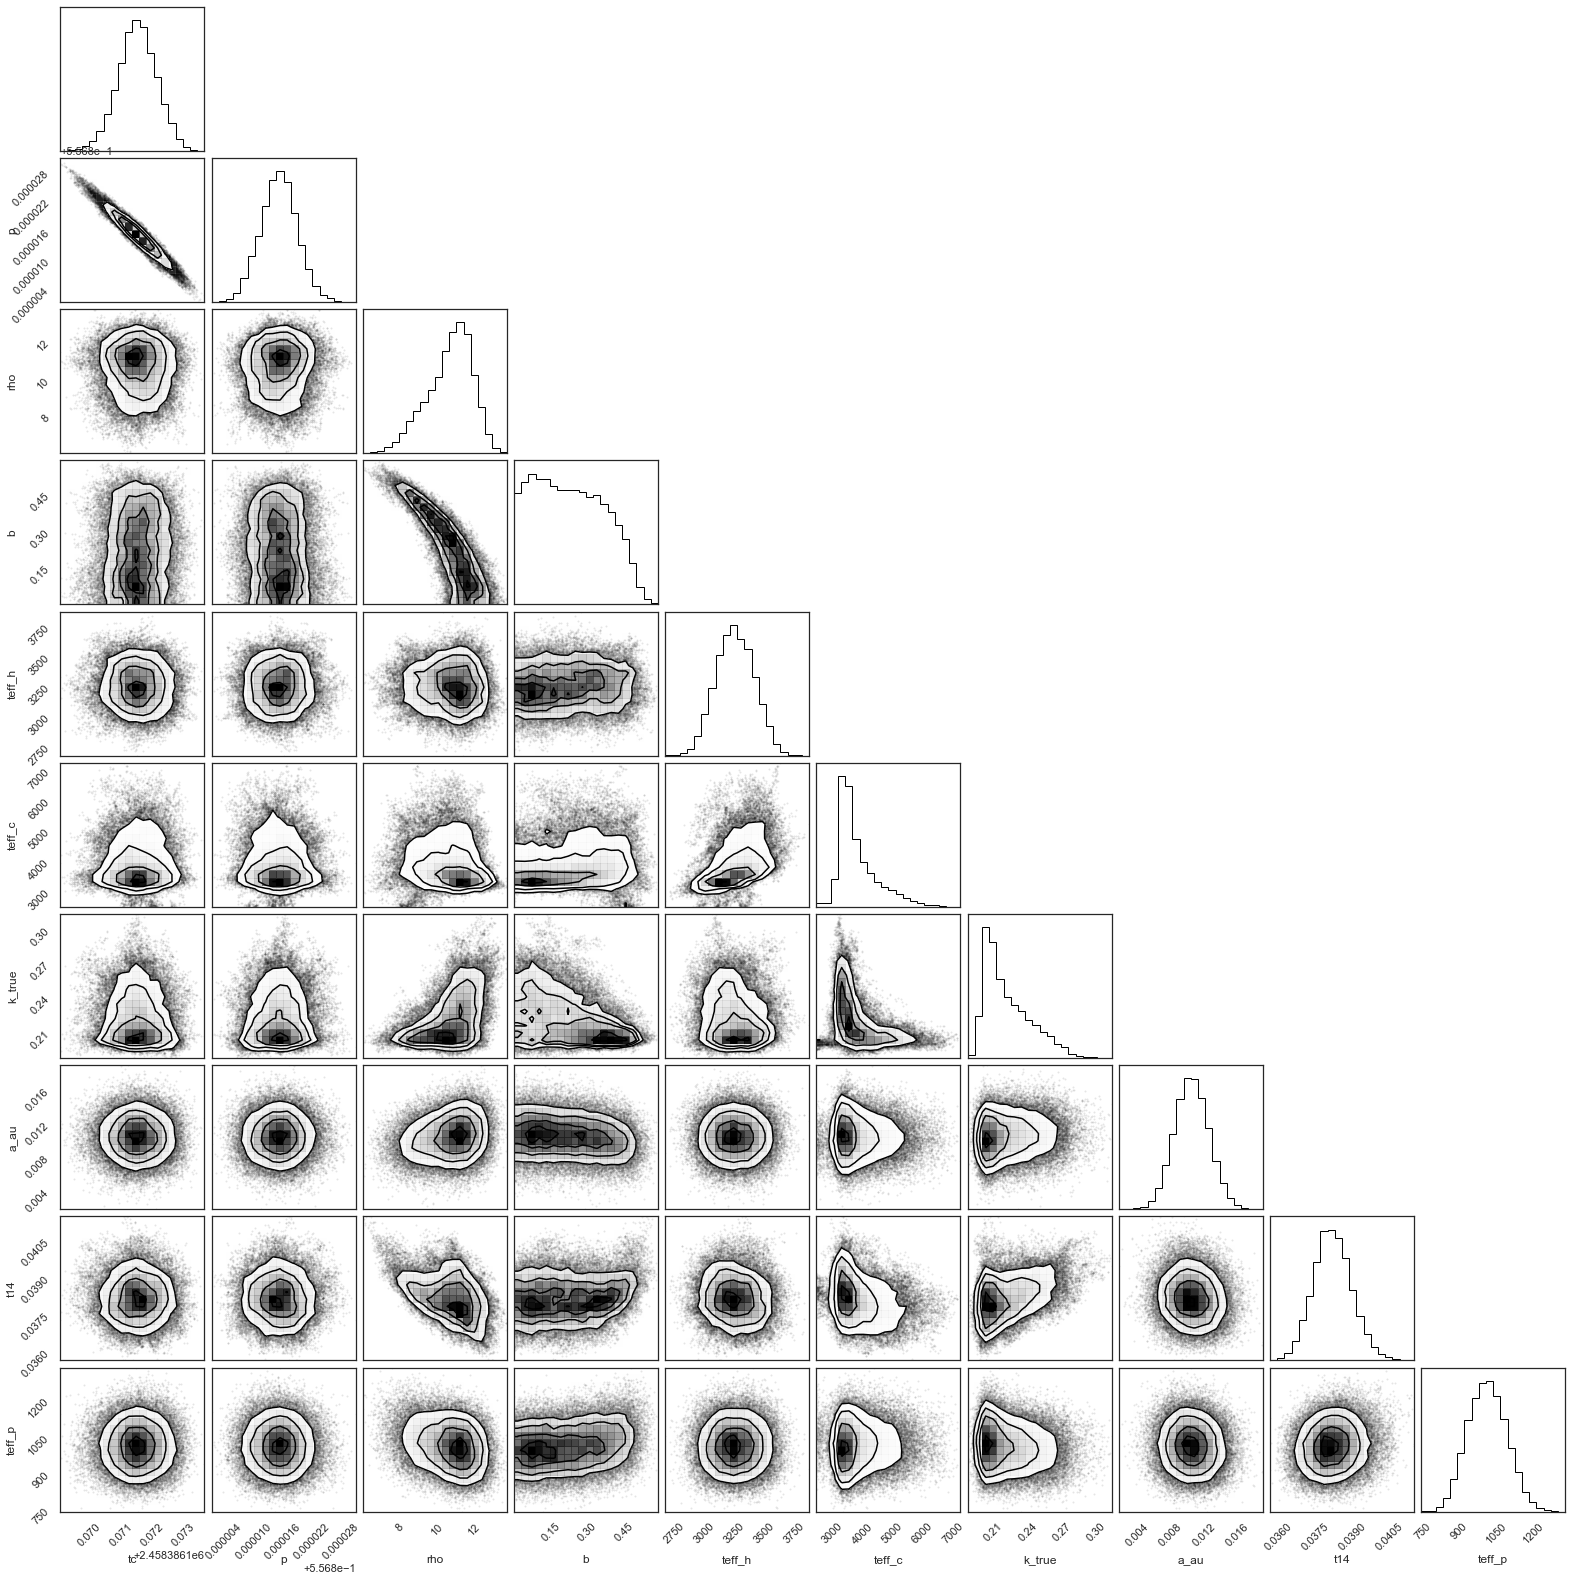

In [21]:
corner(df['tc p rho b teff_h teff_c k_true a_au t14 teff_p'.split()]);

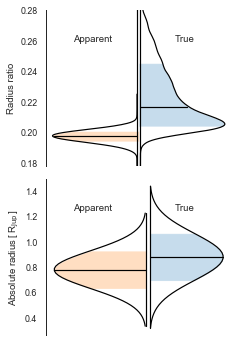

In [48]:
def plot_kdist(samples, sign=1, ax=None, label=None):
    offset = 0.02
    fig, ax = (None, ax) if ax is not None else subplots(figsize=(6,6))
    p = sb.kdeplot(samples, kernel='cos', bw=0.005, gridsize=200, clip=(0.175, 0.29), vertical=True, ax=ax, c='k', legend=False)
    l = p.lines[-1]
    xd = l.get_xdata()
    yd = l.get_ydata()

    m = median(samples)
    my = xd[argmin(abs(yd-m))] / xd.max()
    l.set_xdata(sign*(offset + xd/xd.max()))
    ax.plot((sign*offset,sign*offset), (0.16,0.29), 'k')
    ax.plot((sign*offset, sign*my), (m,m), 'k')
    
    p = percentile(samples, (16,84))
    mask = (yd > p[0]) & (yd < p[1])
    ax.fill_betweenx(yd[mask], sign*(offset+xd[mask]/ xd.max()), alpha=0.25)
    
    #if label:
    #    ax.text(sign*3.5*offset, m+0.0003, label, ha=('left' if sign>0 else 'right'), va='bottom')
    return fig, ax


def plot_ndist(samples, sign=1, yrange=(0.1, 1.4), c='k', ax=None, figsize=(6,6), label=None):
    fig, ax = (None, ax) if ax is not None else subplots(figsize=figsize)
    offset = 0.05
    m, s = samples.mean(), samples.std()
    y = linspace(m-3*s, m+3*s)
    n = norm(m, s)
    ax.plot(sign*(offset + n.pdf(y)), y, c=c)
    ax.plot((sign*offset, sign*(offset+n.pdf(m))),(m, m), c=c)
    ax.plot((sign*offset, sign*offset), (m-3*s, m+3*s), c=c)
    
    y = linspace(m-s, m+s)
    ax.fill_betweenx(y, sign*offset, sign*(offset + n.pdf(y)), alpha=0.25)
    
    #if label:
    #    ax.text(sign*3.5*offset, m+0.1*s, label, ha=('left' if sign>0 else 'right'), va='bottom')
    return fig, ax
    
    
with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAOCW,1.4*AAOCW))
    plot_ndist(df.r_true, label='true R$_\mathrm{\,p}$', ax=axs[1])
    plot_ndist(df.r_app, label='apparent R$_\mathrm{\,p}$', sign=-1, ax=axs[1])
    axs[1].text(0.25, 0.8, 'Apparent', ha='center', transform=axs[1].transAxes)
    axs[1].text(0.75, 0.8, 'True', ha='center', transform=axs[1].transAxes)
    
    plot_kdist(df.k_true, ax=axs[0], label='true k')
    plot_kdist(df.k_app, sign=-1, ax=axs[0], label='apparent k')
    axs[0].text(0.25, 0.8, 'Apparent', ha='center', transform=axs[0].transAxes)
    axs[0].text(0.75, 0.8, 'True', ha='center', transform=axs[0].transAxes)
    
    setp(axs[0], xlim=(-1.1,1.1), ylim=(0.178, 0.28), ylabel='Radius ratio', xticks=[])
    setp(axs[1], ylabel='Absolute radius [$\,$R$_\mathrm{Jup}\,$]', xticks=[])

    #axs[0].set_title('Planet-star radius ratio', size='large')
    #axs[1].set_title('Absolute planet radius', size='large')

    sb.despine(fig, bottom=True)
    fig.tight_layout()
    fig.savefig('plots/k_and_rp_distributions.pdf')

---


<center> © 2019 Hannu Parviainen </center>